# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
df_0.info()
df_1.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261


In [4]:
df_1.info()
df_1.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261


In [5]:
df_2.info()
df_2.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697


In [6]:
def exploratory(data):
    print(f"Shape:    {data.shape}")
    print("Na's:         ", data.isna().sum().sum())
    print("duplicates:   ", data.duplicated().sum())
    print("\nРаспределение признаков:")
    data[["f0","f1","f2"]].hist()
    plt.show()

Shape:    (100000, 5)
Na's:          0
duplicates:    0

Распределение признаков:


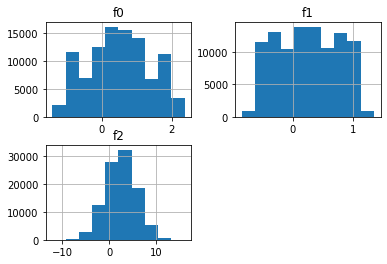

In [7]:
exploratory(df_0)

Shape:    (100000, 5)
Na's:          0
duplicates:    0

Распределение признаков:


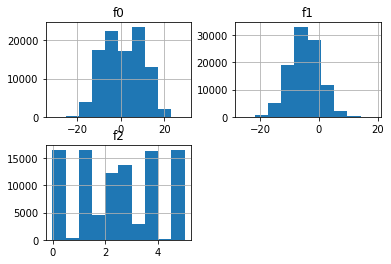

In [8]:
exploratory(df_1)

Shape:    (100000, 5)
Na's:          0
duplicates:    0

Распределение признаков:


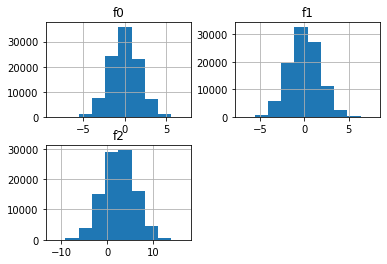

In [9]:
exploratory(df_2)

В данных отсутсвуют пропуски

Признаки для модели:

f0
f1
f2
Целевой признак:

product.
Изучим гистограммы по столбцу product:

In [10]:
def oil_hist(seria, bins, xlim_max, ylim_max):
    plt.figure(figsize=[12,9])
    plt.hist(seria, bins=bins)
    plt.xlim([0,xlim_max])
    plt.ylim([0,ylim_max])
    plt.xlabel("Объем нефти на скважину, тыс. барелей")
    plt.ylabel("Количество скважин")
    plt.title("Гистограмма распределения по объему скважин")
    plt.show()

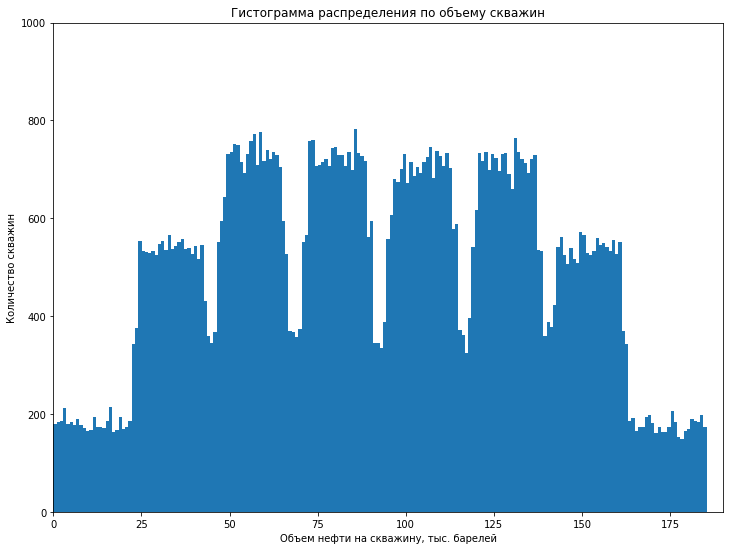

In [11]:
oil_hist(df_0['product'], 200, 190, 1000)

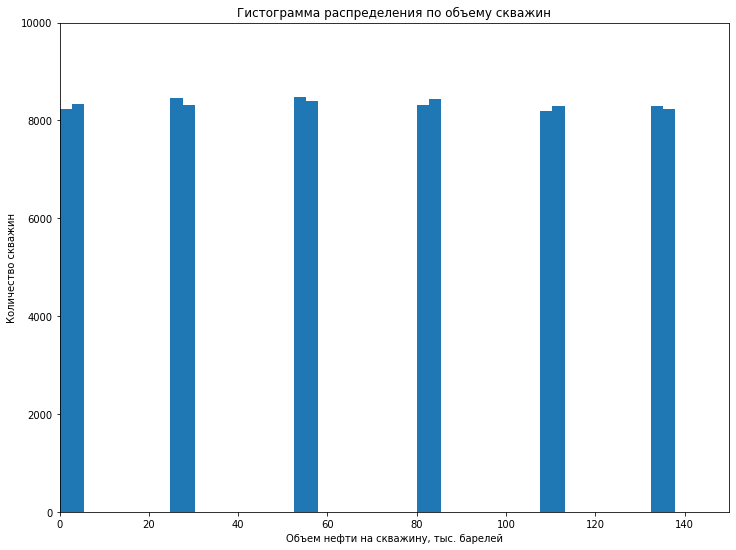

In [12]:
oil_hist(df_1['product'], 50, 150, 10000)

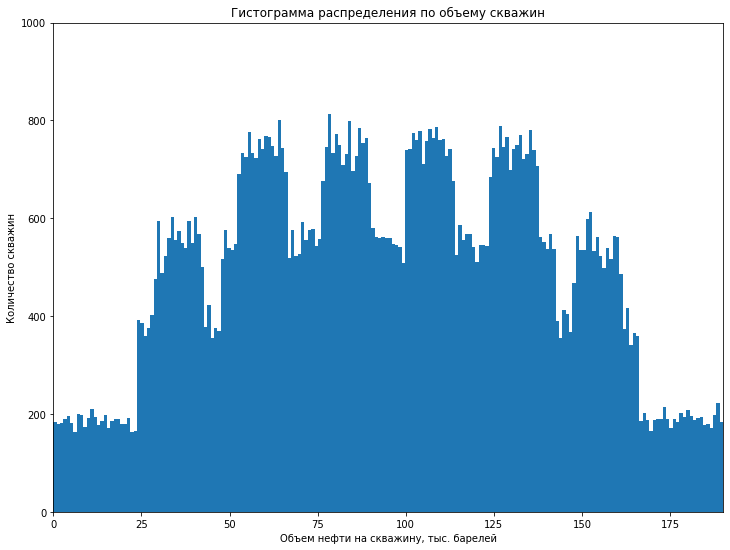

In [13]:
oil_hist(df_2['product'], 200, 190, 1000)

In [14]:
df_0 = df_0.drop(['id'], axis=1)
df_1 = df_1.drop(['id'], axis=1)
df_2 = df_2.drop(['id'], axis=1)

Вывод
Данные готовы к обучению

Во втором месторождении около 8% месторождений не имело значения в столбце product. При сравнении с такими же значениями из первого и третьего региона можно понять, что были утеряны данные или не было исследовано количество барелей нефти

По гистограммам можно понять, что у первого и третьего региона наспределение скважин близкое к нормальному.

Во втором регионе данные имеют странное распределение: от 0 до 5 баррелей с шагом по 15-20 равномерно распределены 100000 значений. Данные не подчиняются закону больших чисел и скорей всего были введены искуственно

## Обучение и проверка модели

Проверим качество модели линейной регрессии с текущим значением признаков и с масштабируемыми. Проверим эту гипотезу на df_1. Выполним разбивку неподготовленного датафрейма:

In [15]:
def test_split(df, target):
    features = df.drop([target] , axis=1)
    target = df[target]

    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=5)
    
    return features_train, features_valid, target_train, target_valid

In [16]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = test_split(df_0, 'product')

In [17]:
features_train_0.head()

,f0,f1,f2
35180,0.596589,-0.423122,-0.599284
80371,0.787058,-0.397987,6.681742
89979,0.889612,0.522944,3.227303
47271,-1.082876,0.382764,0.299522
35664,0.299153,-0.303998,-0.465922


Проведем обучение модели без измененных данных:

In [18]:
model = LinearRegression()

model.fit(features_train_0, target_train_0)
predicted_target_0 = model.predict(features_valid_0)
print('RMSE -', mean_squared_error(target_valid_0, predicted_target_0)**0.5)

RMSE - 37.80284530541535


In [19]:
def test_split_scaled(df, numeric, target):
    df_s = df.copy()

    features_s = df_s.drop([target] , axis=1)
    target_s = df_s[target]

    features_train_s, features_valid_s, target_train_s, target_valid_s = train_test_split(
        features_s, target_s, test_size=0.25, random_state=5062020)

    scaler = StandardScaler()
    scaler.fit(features_train_s[numeric])
    features_train_s[numeric] = scaler.transform(features_train_s[numeric])
    features_valid_s[numeric] = scaler.transform(features_valid_s[numeric])

    return features_train_s, features_valid_s, target_train_s, target_valid_s

Проверим параметр RMSE на маштабированных данных:

In [20]:
features_train_0s, features_valid_0s, target_train_0s, target_valid_0s = test_split_scaled(
                                                                        df_1, ['f0', 'f1', 'f2'], 'product')
model.fit(features_train_0s, target_train_0s)
predicted_target_0s = model.predict(features_valid_0s)
print('RMSE -', mean_squared_error(target_valid_0s, predicted_target_0s)**0.5)

RMSE - 0.8874258342572864


In [21]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = test_split(df_1, 'product')
model.fit(features_train_1, target_train_1)
predicted_target_1 = model.predict(features_valid_1)
print('RMSE -', mean_squared_error(target_valid_1, predicted_target_1)**0.5)

features_train_1s, features_valid_1s, target_train_1s, target_valid_1s = test_split_scaled(
                                                                        df_1, ['f0', 'f1', 'f2'], 'product')
model.fit(features_train_1s, target_train_1s)
predicted_target_1s = model.predict(features_valid_1s)
print('RMSE -', mean_squared_error(target_valid_1s, predicted_target_1s)**0.5)

RMSE - 0.8911637870714586
RMSE - 0.8874258342572864


In [22]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = test_split(df_2, 'product')
model.fit(features_train_2, target_train_2)
predicted_target_2 = model.predict(features_valid_2)
print('RMSE -', mean_squared_error(target_valid_2, predicted_target_2)**0.5)

features_train_2s, features_valid_2s, target_train_2s, target_valid_2s = test_split_scaled(
                                                                        df_2, ['f0', 'f1', 'f2'], 'product')
model.fit(features_train_2s, target_train_2s)
predicted_target_2s = model.predict(features_valid_2s)
print('RMSE -', mean_squared_error(target_valid_2s, predicted_target_2s)**0.5)

RMSE - 40.27855914124022
RMSE - 40.18553497171235


In [23]:
model = LinearRegression(normalize=True)
model.fit(features_train_1, target_train_1)
predicted_target_1 = model.predict(features_valid_1)
print('RMSE -', mean_squared_error(target_valid_1, predicted_target_1)**0.5)

RMSE - 0.8911637870714586


In [24]:
model = LinearRegression(fit_intercept=False)
model.fit(features_train_1, target_train_1)
predicted_target_1 = model.predict(features_valid_1)
print('RMSE -', mean_squared_error(target_valid_1, predicted_target_1)**0.5)

RMSE - 1.2128079436885901


Произведем вывод предсказанного запаса с реальным и выведем RMSE:

In [25]:
model = LinearRegression()

def oil_predict(df, target_name):
    features = df.drop([target_name] , axis=1)
    target = df[target_name]
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=5)
    
    model.fit(features_train, target_train)
    predicted_target = model.predict(features_valid)
    data = {'real_product' : target_valid,
            'predicted_product' : predicted_target         
    }
    data_frame = pd.DataFrame(data, columns = ['real_product', 'predicted_product'])
    rmse = mean_squared_error(target_valid, predicted_target)**0.5
    mean = data_frame['predicted_product'].mean()
    oil_sum = data_frame['predicted_product'].sum()
    return data_frame, rmse, mean, oil_sum

In [26]:
df_0_predicted, df_0_rmse, df_0_predicted_mean, df_0_predicted_sum = oil_predict(df_0, 'product')

In [27]:
df_0_predicted.head()

,real_product,predicted_product
60743,119.220564,118.026686
33949,169.808150,110.858985
52805,131.589165,76.589517
11804,144.585224,100.990823
9229,184.075418,90.048812


In [28]:
print('RMSE -', df_0_rmse)
print('Средний запас запасанного сырья -', df_0_predicted_mean)

RMSE - 37.80284530541535
Средний запас запасанного сырья - 92.62394691552272


In [29]:
df_1_predicted, df_1_rmse, df_1_predicted_mean, df_1_predicted_sum = oil_predict(df_1, 'product')

In [30]:
df_1_predicted.head()

,real_product,predicted_product
60743,80.859783,80.991708
33949,53.906522,53.729323
52805,3.179103,3.751569
11804,107.813044,108.245842
9229,80.859783,82.008314


In [31]:
print('RMSE -', df_1_rmse)
print('Средний запас запасанного сырья -', df_1_predicted_mean)

RMSE - 0.8911637870714586
Средний запас запасанного сырья - 68.64756489237209


In [32]:
df_2_predicted, df_2_rmse, df_2_predicted_mean, df_2_predicted_sum = oil_predict(df_2, 'product')

In [33]:
df_2_predicted.head()

,real_product,predicted_product
60743,186.714538,88.685519
33949,73.641755,118.919701
52805,125.190694,98.429155
11804,130.826729,114.772869
9229,14.983400,54.375878


In [34]:
print('RMSE -', df_2_rmse)
print('Средний запас запасанного сырья -', df_2_predicted_mean)

RMSE - 40.27855914124022
Средний запас запасанного сырья - 95.02417827030403


In [35]:
print('Суммарный предсказанный запас в позиции 1 -', df_0_predicted_sum)
print('Суммарный реальный запас в позиции 1 -', df_0_predicted['real_product'].sum())
print()
print('Суммарный предсказанный запас в позиции 2 -', df_1_predicted_sum)
print('Суммарный реальный запас в позиции 2 -', df_1_predicted['real_product'].sum())
print()
print('Суммарный предсказанный запас в позиции 3 -', df_2_predicted_sum)
print('Суммарный реальный запас в позиции 3 -', df_2_predicted['real_product'].sum())

Суммарный предсказанный запас в позиции 1 - 2315598.672888068
Суммарный реальный запас в позиции 1 - 2322579.7884419193

Суммарный предсказанный запас в позиции 2 - 1716189.1223093022
Суммарный реальный запас в позиции 2 - 1716031.8878765225

Суммарный предсказанный запас в позиции 3 - 2375604.456757601
Суммарный реальный запас в позиции 3 - 2377216.735320481


Вывод
Данные предсказаний о количестве нефти по сумме примерно совпадают по сумме с предсказанными значениями. Лучше всего модель предсказала запасы во втором регионе (RMSE - 0.88), далее в первом и третьем соотвественно.
Возможно утеряные данные из второго региона сказались на модели и она достаточно сильно переобучилась. Но из-за утери данных и малого запаса в среднем на месторождение не имеет смысла рассматривать второе месторождение как прибыльное.
Изучим все регионы на риски и прибыль, но в конечном итоге будем выбирать между 1 и 3 регионом

## Подготовка к расчёту прибыли

Создадим переменные об экономической информации:

In [36]:
BUDGET = 1e+07
POINTS = 500
BEST_POINTS = 200
PRICE_PER_BARREL = 450

Мы расчитываем прибыль в тысячах рублей за тысячу барелей, поэтому 1 милиард сохранен таким образом

Расчитаем безубыточную разработку сырья на 200 месторождениях. И найдем среднее количество продукта в месторождениях необходимое для этого:

In [37]:
average_profit_per_point = BUDGET / BEST_POINTS
print('Средняя прибыль на лучшую точку -', average_profit_per_point, 'тыс.руб.')

Средняя прибыль на лучшую точку - 50000.0 тыс.руб.


In [38]:
average_barrels_per_point = average_profit_per_point  / PRICE_PER_BARREL
print('Средний объем нефти на точку -',average_barrels_per_point, 'тыс. барелей')

Средний объем нефти на точку - 111.11111111111111 тыс. барелей


In [39]:
average_barrels = BUDGET / PRICE_PER_BARREL
print('Средний объем нефти на регион -',average_barrels, 'тыс. барелей')

Средний объем нефти на регион - 22222.222222222223 тыс. барелей


In [40]:
print('Средний запас фактичекой нефти на скважину в регионе 1', df_0['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 2', df_1['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 3', df_2['product'].mean())

Средний запас фактичекой нефти на скважину в регионе 1 92.50000000000001
Средний запас фактичекой нефти на скважину в регионе 2 68.82500000000002
Средний запас фактичекой нефти на скважину в регионе 3 95.00000000000004


Создадим функцию для расчета приыли на 500 разведанных точек:

In [41]:
def oil_profit_calc(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return PRICE_PER_BARREL * selected.sum() - BUDGET

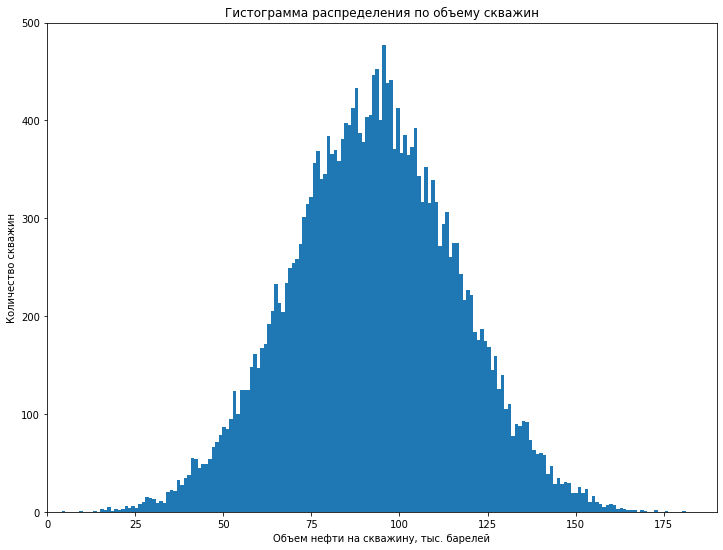

In [42]:
oil_hist(df_0_predicted['predicted_product'], 200, 190, 500)

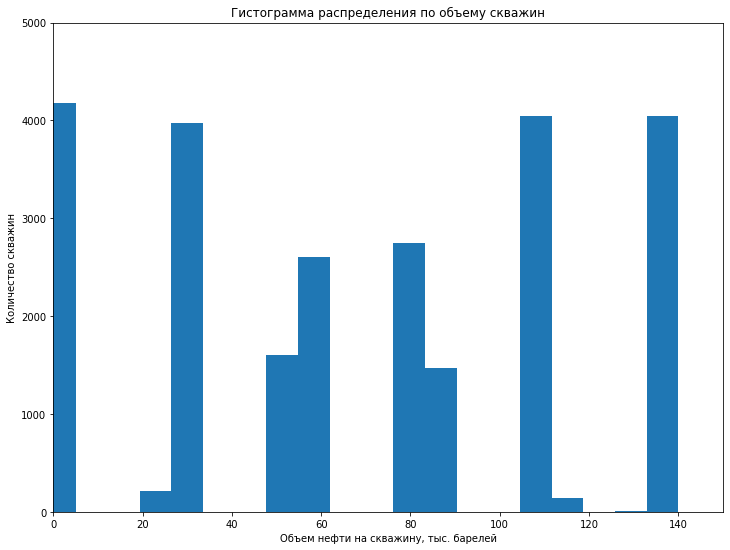

In [43]:
oil_hist(df_1_predicted['predicted_product'], 20, 150, 5000)

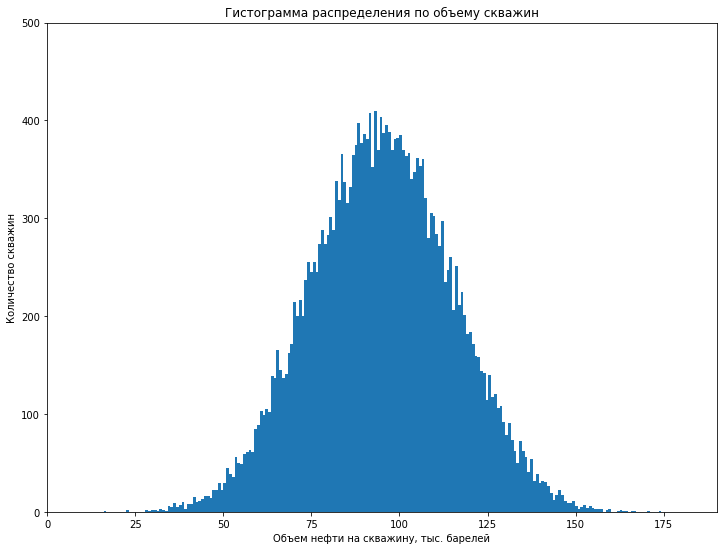

In [44]:
oil_hist(df_2_predicted['predicted_product'], 200, 190, 500)

**Вывод**

    Была подготовлена средняя оценка прибыли за скважину и средний объем на скважину.
    Создана функция по расчету прибыли.
    Анализ средних объемов на скважину для каждого региона следующий (изучены средние фактические запасы):

    Для первого и третьего - высокая вероятность окупить затраты. Разброс значений вокруг среднего 92.5 и 95 говорит нам о том, что существует достаточно много скважин, где запасы больше необходимого среднего

    Во вторых данных возможно и есть определенный смысл - значений больше 111 (т.е достаточно много) и при определенной доли везения можно выбрать только лучшие в этой выборке (хотя среднее значение 68.8)

## Расчёт прибыли и рисков 

создадим функцию

In [45]:
state = np.random.RandomState(5)
def bootstrap_1000(target, probs):
    values=[]
    lost = 0
    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=state, n=POINTS)
        probs_sample = probs[target_sample.index]
        profit = oil_profit_calc(target, probs_sample, BEST_POINTS)
        if profit < 0:
            lost +=1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = lost / 1000
    return average, lower, upper, risk

Теперь используем данные получившейся функции в наших датасетах:

In [46]:
average_1, lower_1, upper_1, risk_1 = bootstrap_1000(df_0_predicted['real_product'], 
                                                     df_0_predicted['predicted_product'])

In [47]:
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_1))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_1, upper_1))
print('Процент риска {:.2%}'.format(risk_1))

Средняя прибыль по региону = 457194.86 тыс.руб.
95% доверительный интервал от -75265.84 до 957514.50 тыс.руб.
Процент риска 4.30%


In [48]:
average_1, lower_1, upper_1, risk_1 = bootstrap_1000(df_1_predicted['real_product'], 
                                                     df_1_predicted['predicted_product'])

In [49]:
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_1))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_1, upper_1))
print('Процент риска {:.2%}'.format(risk_1))

Средняя прибыль по региону = 423523.86 тыс.руб.
95% доверительный интервал от 40418.36 до 810180.17 тыс.руб.
Процент риска 1.30%


In [50]:
average_2, lower_2, upper_2, risk_2 = bootstrap_1000(df_2_predicted['real_product'], 
                                                     df_2_predicted['predicted_product'])

In [51]:
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_1))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_1, upper_1))
print('Процент риска {:.2%}'.format(risk_1))

Средняя прибыль по региону = 423523.86 тыс.руб.
95% доверительный интервал от 40418.36 до 810180.17 тыс.руб.
Процент риска 1.30%


Данные по первому региону:

Средняя прибыль по региону = 457194.86 тыс.руб.
95% доверительный интервал от -75265.84 до 957514.50 тыс.руб.
Процент риска 4.30%

Данные по второму региону:

Средняя прибыль по региону = 423523.86 тыс.руб.
95% доверительный интервал от 40418.36 до 810180.17 тыс.руб.
Процент риска 1.30%

Данные по третьему региону:

Средняя прибыль по региону = 322245.06 тыс.руб.
95% доверительный интервал от -197408.50 до 878417.19 тыс.руб.
Процент риска 11.90%

### Общий вывод

**Первый регион:**

Средняя прибыль по региону = 457194.86 тыс.руб.

95% доверительный интервал от -75265.84 до 957514.50 тыс.руб.

Процент риска 4.30%

**Второй регион:**

Средняя прибыль по региону = 423523.86 тыс.руб.

95% доверительный интервал от 40418.36 до 810180.17 тыс.руб.

Процент риска 1.30%

**Третий регион:**

Средняя прибыль по региону = 322245.06 тыс.руб.

95% доверительный интервал от -197408.50 до 878417.19 тыс.руб.

Процент риска 11.90%

**Итог:**

Мы отсеиваем третий регион, так как у этого региона нибольший процент риска - 11.9%
Остаются два региона - первый (процент риска 4.3%) и второй (процент риска 1.3%)
У второго региона наименьший % риска и, кроме того, доверительный интервал показывает, что даже при не очень удачном выборе разработка скважин окупится, так что лучше выбрать его.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован